# Combined Mitigation

In [21]:
from my_rem import *
from my_ddd import *
from typing import List, Callable
import numpy as np
from matplotlib import pyplot as plt

import qiskit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

from mitiq.interface.mitiq_qiskit import to_qiskit
from mitiq import ddd, QPROGRAM
from mitiq.ddd import insert_ddd_sequences

In [34]:
#Define Errors we want to mitigate

from qiskit_aer.noise import depolarizing_error, QuantumError

# Define the probability values
p_readout_flip = 0.1
p_circuit_depolarizing = 0.1

# Measurement error (bit-flip error)
error_meas = pauli_error([('X', p_readout_flip), ('I', 1 - p_readout_flip)])

# Single-qubit depolarizing error
error_depolarizing_1q = depolarizing_error(p_circuit_depolarizing, 1)

# Two-qubit depolarizing error
error_depolarizing_2q = depolarizing_error(p_circuit_depolarizing, 2)

In [35]:
# Create Combined Model of the Noises affecting the circuit (Should this be generalized to add arbitrary many sources of error of arbitrary type ??? Is it needed?)
# If you end up generalizing, move to a library. Otherwise keep here for clarity of usage

def get_combined_noise(error_meas: QuantumError, error_depolarizing_1q: QuantumError, error_depolarizing_2q: QuantumError):
    """Create a noise model with specified errors during measurement and operations."""
    
    noise_model = NoiseModel()
    
    # Add measurement error to all qubits
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    
    # Add single-qubit depolarizing error to all single-qubit gates
    noise_model.add_all_qubit_quantum_error(error_depolarizing_1q, ['u1', 'u2', 'u3'])
    
    # Add two-qubit depolarizing error to all two-qubit gates
    noise_model.add_all_qubit_quantum_error(error_depolarizing_2q, 'cx')
    
    return noise_model


In [36]:
import cirq

# Importing the cirq module

# Defining a function for the repeated ixix rule
def rep_ixix_rule(window_length: int) -> Callable[[int], QPROGRAM]:
    return ddd.rules.repeated_rule(
        window_length, [cirq.I, cirq.X, cirq.I, cirq.X]
    )

# Defining a function for the repeated xx rule
def rep_xx_rule(window_length: int) -> Callable[[int], QPROGRAM]:
    return ddd.rules.repeated_rule(window_length, [cirq.X, cirq.X])

# Set DDD sequences to test.
rules = [rep_ixix_rule, rep_xx_rule, ddd.rules.xx]

# Test the sequence insertion
for rule in rules:
    print(rule(10))

0: ───I───I───X───I───X───I───X───I───X───I───
0: ───X───X───X───X───X───X───X───X───X───X───
0: ───I───I───I───X───I───I───X───I───I───I───


In [37]:
def run_and_mitigate(circuit, noise: NoiseModel=None, reps=1000, mitigator=False, ddd=False, n_qubits=None, shots=None, ddd_rule=None, output=False):
    """
    High-level function to apply error mitigation and/or dynamical decoupling.

    Parameters:
    - circuit: The quantum circuit to modify.
    - noise: The noise model to apply to the circuit.
    - reps: Number of repetitions to run the circuit.
    - mitigator: Boolean flag to apply error mitigation.
    - ddd: Boolean flag to apply DDD rules.
    - n_qubits: Number of qubits for the mitigator (only needed if mitigator is True).
    - shots: Number of shots for the mitigator (only needed if mitigator is True).
    - ddd_rule: The rule to apply for DDD (only needed if ddd is True).
    - output: Boolean flag to control the print statements.
    """
    new_circuit = circuit.copy() # To leave circuit invariant after execution

    if mitigator:
        if n_qubits is None or shots is None:
            raise ValueError("n_qubits and shots must be specified if mitigator is True")
        
        if output:
            print("Computing Mitigator ... \n")
        # Assuming get_readout_noise and generate_mitigator are defined elsewhere in the notebook
        readout_noise = get_readout_noise(error_meas)
        mitigator_instance = generate_mitigator(n_qubits, shots, readout_noise, False)
    
    if ddd:
        if ddd_rule is None:
            raise ValueError("ddd_rule must be specified if ddd is True")
        
        if output:
            print("Original circuit")
            print(circuit)
            print("Inserting DDD sequences ... \n")
        new_circuit = insert_ddd_sequences(circuit, ddd_rule)
        if output:
            print(new_circuit)

    if output:
        print(f"Running the circuit ... for {reps} repetitions \n")
    simulator = AerSimulator(noise_model=noise)
    counts = simulator.run(new_circuit, shots=reps).result().get_counts(new_circuit)
    
    # Normalize the counts to get probabilities
    num_bit_strings = 2 ** n_qubits
    bit_strings = [format(i, '0{}b'.format(n_qubits)) for i in range(num_bit_strings)]
    
    # Initialize probabilities dictionary with all bit strings and initial probability 0.0
    probabilities = {bit_string: 0.0 for bit_string in bit_strings}
    
    # Update probabilities based on counts
    for k, v in counts.items():
        probabilities[k] = v / reps

    if mitigator:
        probability_vector = np.array([probability for state, probability in sorted(probabilities.items(), key=lambda x: int(x[0], 2))])
        mitigated_probabilities = np.dot(mitigator_instance, probability_vector)
        closest_probabilities = closest_positive_distribution(mitigated_probabilities)
        if output:
            print("Empirical probabilities:", probability_vector)
            print("Mitigated quasi-probabilities:", mitigated_probabilities)
            print("Closest positive probabilities:", closest_probabilities)
        probabilities = {state: prob for state, prob in zip(sorted(probabilities, key=lambda x: int(x, 2)), closest_probabilities)}
    
    if output:
        print(f"Final Probabilities={probabilities}")
        print("\n \n")
    
    return probabilities


# Example Usage

In [46]:
# Initialize a random circuit

num_qubits = 2  # Number of qubits in the circuit
num_operations = 5  # Number of initial random operations
idle_depth = 20  # Number of idle operations to add
circuit = create_random_circuit_with_idle_windows(num_qubits, num_operations, idle_depth)

In [47]:
# Define parameters for the high-level function
reps = 100000
noise = get_combined_noise(error_meas,error_depolarizing_1q, error_depolarizing_2q)
mitigator_flag = True
ddd_flag = True
n_qubits = 2
shots = 10000
ddd_sequence = ddd.rules.xx  # Use appropriate DDD sequence from mitiq

# Apply the high-level function
results = run_and_mitigate(
    circuit,
    noise = None,
    reps = reps,
    mitigator=mitigator_flag,
    ddd=ddd_flag,
    n_qubits=n_qubits,
    shots=shots,
    ddd_rule=ddd_sequence,
    output=False
)

print(results)

{'00': 0.5005503127415621, '01': 0.0, '10': 0.4994496872584378, '11': 0.0}


In [48]:
import numpy as np
from matplotlib import pyplot as plt

def run_cases(circuit, noise: NoiseModel=None, reps=1000, n_qubits=None, shots=None, ddd_rule=None):
    """
    Runs the `run_and_mitigate` function for five cases and plots the results in a merged histogram.
    
    Parameters:
    - circuit: The quantum circuit to modify.
    - noise: The noise model to apply to the circuit.
    - reps: Number of repetitions to run the circuit.
    - n_qubits: Number of qubits for the mitigator.
    - shots: Number of shots for the mitigator.
    - ddd_rule: The rule to apply for DDD.
    """
    
    # Case 1: No noise, no mitigation
    print("Running with no noise, no mitigation ... \n")
    result_no_noise_no_mit = run_and_mitigate(circuit, noise=None, reps=reps, mitigator=False, ddd=False, n_qubits=n_qubits, shots=shots, ddd_rule=ddd_rule)
    
    # Case 2: Noise, no mitigation
    print("Running with noise, no mitigation ... \n")
    result_noise_no_mit = run_and_mitigate(circuit, noise=noise, reps=reps, mitigator=False, ddd=False, n_qubits=n_qubits, shots=shots, ddd_rule=ddd_rule)
    
    # Case 3: Noise, mitigation True, DDD False
    print("Running with noise, mitigation True, DDD False  \n")
    result_noise_rem_no_ddd = run_and_mitigate(circuit, noise=noise, reps=reps, mitigator=True, ddd=False, n_qubits=n_qubits, shots=shots, ddd_rule=ddd_rule)
    
    # Case 4: Noise, mitigation False, DDD True
    print("Running with noise, mitigation False, DDD True  \n")
    result_noise_no_rem_ddd = run_and_mitigate(circuit, noise=noise, reps=reps, mitigator=False, ddd=True, n_qubits=n_qubits, shots=shots, ddd_rule=ddd_rule)
    
    # Case 5: Noise, mitigation True, DDD True
    print("Running with noise, mitigation True, DDD True  \n")
    result_noise_rem_ddd = run_and_mitigate(circuit, noise=noise, reps=reps, mitigator=True, ddd=True, n_qubits=n_qubits, shots=shots, ddd_rule=ddd_rule)
    
    return result_no_noise_no_mit, result_noise_no_mit, result_noise_rem_no_ddd, result_noise_no_rem_ddd, result_noise_rem_ddd


In [49]:
# Assuming you have already defined the circuit, noise model, and other necessary parameters
result_no_noise_no_mit, result_noise_no_mit, result_noise_rem_no_ddd, result_noise_no_rem_ddd, result_noise_rem_ddd = run_cases(circuit, noise=noise, reps=1000, n_qubits=2, shots=10000, ddd_rule=ddd.rules.xx)
results_list = [result_no_noise_no_mit, result_noise_no_mit, result_noise_rem_no_ddd, result_noise_no_rem_ddd, result_noise_rem_ddd]
print(results_list)

Running with no noise, no mitigation ... 

Running with noise, no mitigation ... 

Running with noise, mitigation True, DDD False  

Running with noise, mitigation False, DDD True  

Running with noise, mitigation True, DDD True  

[{'00': 0.498, '01': 0.0, '10': 0.502, '11': 0.0}, {'00': 0.402, '01': 0.086, '10': 0.421, '11': 0.091}, {'00': 0.4543816609267504, '01': 0.054799190172246125, '10': 0.4341300077993564, '11': 0.05668914110164709}, {'00': 0.413, '01': 0.086, '10': 0.424, '11': 0.077}, {'00': 0.4574229287142772, '01': 0.0191720381951397, '10': 0.4802207289211288, '11': 0.04318430416945423}]


Text(0, 0.5, 'Probabilities')

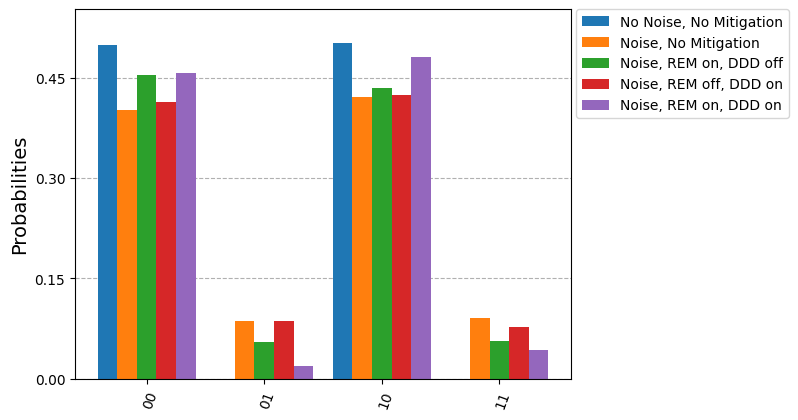

In [50]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


labels = [
    'No Noise, No Mitigation', 'Noise, No Mitigation',
    'Noise, REM on, DDD off', 'Noise, REM off, DDD on', 'Noise, REM on, DDD on'
]


# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Now, use the ax parameter to specify where to plot the histogram
plot_histogram(results_list, legend=labels, bar_labels=False, ax=ax)
ax.set_ylabel('Probabilities')

# Study the Performance based on distance

In [51]:
import numpy as np
from typing import Dict

def distance(prob_dist_1: Dict[str, float], prob_dist_2: Dict[str, float]) -> np.float64:
    """Calculate the distance between two probability distributions given as dictionaries."""
    def extract_probabilities(result: Dict[str, float]) -> np.ndarray:
        """Extract the probabilities from the dictionary and convert to a NumPy array."""
        return np.array([result['00'], result['01'], result['10'], result['11']])
    
    prob_array_1 = extract_probabilities(prob_dist_1)
    prob_array_2 = extract_probabilities(prob_dist_2)
    
    return np.linalg.norm(prob_array_1 - prob_array_2)  # Calculate the Euclidean distance

In [52]:

def run_experiment(n: int, num_qubits: int, num_operations: int, idle_depth: int, noise, reps: int, shots: int, ddd_rule) -> List[np.float64]:
    avg_distances = np.zeros(4)

    for _ in range(n):
        print(f"Running experiment {_}... \n")
        circuit = create_random_circuit_with_idle_windows(num_qubits, num_operations, idle_depth)
        result_no_noise_no_mit, result_noise_no_mit, result_noise_rem_no_ddd, result_noise_no_rem_ddd, result_noise_rem_ddd = run_cases(
            circuit, noise=noise, reps=reps, n_qubits=num_qubits, shots=shots, ddd_rule=ddd_rule
        )

        distance_no_mit = distance(result_no_noise_no_mit, result_noise_no_mit)
        distance_rem_no_ddd = distance(result_no_noise_no_mit, result_noise_rem_no_ddd)
        distance_no_rem_ddd = distance(result_no_noise_no_mit, result_noise_no_rem_ddd)
        distance_rem_ddd = distance(result_no_noise_no_mit, result_noise_rem_ddd)

        avg_distances[0] += distance_no_mit
        avg_distances[1] += distance_rem_no_ddd
        avg_distances[2] += distance_no_rem_ddd
        avg_distances[3] += distance_rem_ddd

    avg_distances /= n

    return avg_distances

# Parameters
n = 10  # Number of repetitions
num_qubits = 2  # Number of qubits in the circuit
num_operations = 5  # Number of initial random operations
idle_depth = 20  # Number of idle operations to add
noise = noise  # Define your noise model here
reps = 1000
shots = 10000
ddd_rule = ddd.rules.xx  # Define your DDD rule here

# Run experiment
avg_distances = run_experiment(n, num_qubits, num_operations, idle_depth, noise, reps, shots, ddd_rule)

Running experiment 0... 

Running with no noise, no mitigation ... 

Running with noise, no mitigation ... 

Running with noise, mitigation True, DDD False  

Running with noise, mitigation False, DDD True  

Running with noise, mitigation True, DDD True  

Running experiment 1... 

Running with no noise, no mitigation ... 

Running with noise, no mitigation ... 

Running with noise, mitigation True, DDD False  

Running with noise, mitigation False, DDD True  

Running with noise, mitigation True, DDD True  

Running experiment 2... 

Running with no noise, no mitigation ... 

Running with noise, no mitigation ... 

Running with noise, mitigation True, DDD False  

Running with noise, mitigation False, DDD True  

Running with noise, mitigation True, DDD True  

Running experiment 3... 

Running with no noise, no mitigation ... 

Running with noise, no mitigation ... 

Running with noise, mitigation True, DDD False  

Running with noise, mitigation False, DDD True  

Running with nois

In [53]:
# Print average distances
print("Average distance to result_noise_no_mit from ideal :", avg_distances[0])
print("Average distance to result_noise_rem_no_ddd from ideal :", avg_distances[1])
print("Average distance to result_noise_no_rem_ddd from ideal :", avg_distances[2])
print("Average distance to result_noise_rem_ddd from ideal :", avg_distances[3])

Average distance to result_noise_no_mit from ideal : 0.19809193449668233
Average distance to result_noise_rem_no_ddd from ideal : 0.0806677935407365
Average distance to result_noise_no_rem_ddd from ideal : 0.19550934206730006
Average distance to result_noise_rem_ddd from ideal : 0.07649748614740524


Adding the DDD doesn't seem to make much a difference. The rule probably needs to be chosen according to the error type (look into it). And also how important is the corresponding error rate.